### This is an example of what happens when you use a bad reference in for label transfer

In [1]:
!curl -O "https://czb-tabula-muris-senis.s3.us-west-2.amazonaws.com/Data-objects/tabula-muris-senis-droplet-official-raw-obj.h5ad"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3868M  100 3868M    0     0  35.6M      0  0:01:48  0:01:48 --:--:-- 40.4M


In [36]:
import scanpy as sc
import pandas as pd
import scvi
import celltypist
from celltypist import models

In [3]:
ref_data = sc.read_h5ad('tabula-muris-senis-droplet-official-raw-obj.h5ad')

In [4]:
ref_data.obs.tissue.unique().tolist()

['Tongue',
 'Heart_and_Aorta',
 'Marrow',
 'Mammary_Gland',
 'Fat',
 'Kidney',
 'Liver',
 'Lung',
 'Limb_Muscle',
 'Pancreas',
 'Spleen',
 'Thymus',
 'Bladder',
 'Skin',
 'Large_Intestine',
 'Trachea']

In [ ]:
#We will be mapping labels from a lung dataset onto heart data

In [12]:
ref = ref_data[ref_data.obs.tissue == 'Lung'].copy()

In [13]:
query = ref_data[ref_data.obs.tissue == 'Heart_and_Aorta'].copy()

In [18]:
ref.obs['Batch'] = 'ref'
query.obs['Batch'] = 'query'

In [19]:
ref.obs['CellType'] = ref.obs.cell_ontology_class
query.obs['CellType'] = 'Unknown'

In [20]:
data = sc.concat((ref, query))

In [21]:
data

AnnData object with n_obs × n_vars = 33153 × 20138
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'Batch', 'CellType'

In [22]:
sc.pp.highly_variable_genes(data, flavor = 'seurat_v3', n_top_genes=2000, batch_key="Batch", subset = True)

In [23]:
scvi.model.SCVI.setup_anndata(data, batch_key='Batch')
vae = scvi.model.SCVI(data)
vae.train()

Unable to initialize backend 'cuda': 
Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 241/241: 100%|█| 241/241 [06:34<00:00,  1.60s/it, v_num=1, train_loss_step

`Trainer.fit` stopped: `max_epochs=241` reached.


Epoch 241/241: 100%|█| 241/241 [06:34<00:00,  1.64s/it, v_num=1, train_loss_step


In [25]:
lvae = scvi.model.SCANVI.from_scvi_model(vae, adata = data, unlabeled_category = 'Unknown',
                                        labels_key = 'CellType')

lvae.train(n_samples_per_label=100)


INFO     Training for 10 epochs.                                                                                   


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 10/10: 100%|█| 10/10 [00:39<00:00,  3.91s/it, v_num=1, train_loss_step=583

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|█| 10/10 [00:39<00:00,  3.91s/it, v_num=1, train_loss_step=583


In [27]:
data.obsm['X_scVI'] = vae.get_latent_representation()
sc.pp.neighbors(data, use_rep = 'X_scVI')
data.obs['predicted'] = lvae.predict(data)
data.obs['transfer_score'] = lvae.predict(soft = True).max(axis = 1)
sc.tl.umap(data)

In [30]:
data_sub = data[data.obs.Batch == 'query']

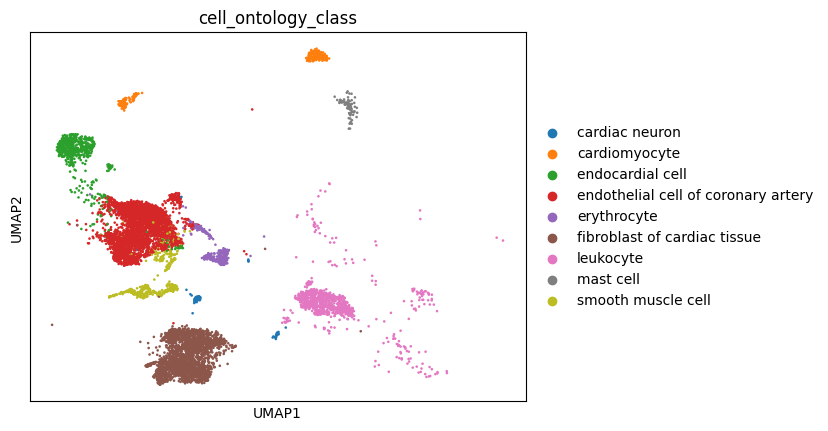

In [33]:
sc.pl.umap(data_sub, color = ['cell_ontology_class']) #actual

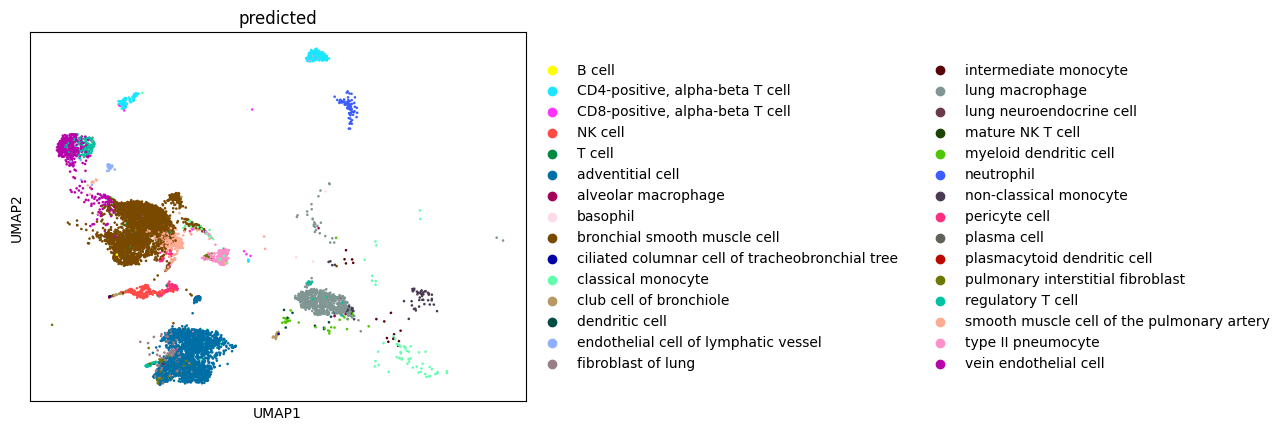

In [34]:
sc.pl.umap(data_sub, color = ['predicted']) #transfered

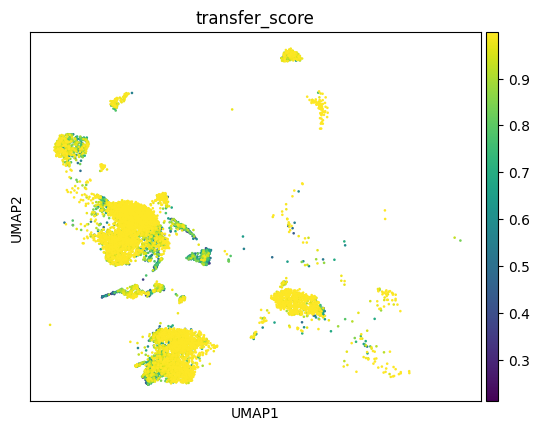

In [35]:
sc.pl.umap(data_sub, color = ['transfer_score'])

In [ ]:
#method 2 with celltypist

In [38]:
sc.pp.normalize_total(ref, target_sum=1e4)
sc.pp.log1p(ref)

In [39]:
ref_model = celltypist.train(ref, labels = 'CellType', n_jobs = 22,
                            use_SGD = False,
                            feature_selection = True, top_genes = 300)

🍳 Preparing data before training
✂️ 1995 non-expressed genes are filtered out
🔬 Input data has 24540 cells and 18143 genes
⚖️ Scaling input data
🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 4901 features are selected
🏋️ Starting the second round of training
🏋️ Training data using logistic regression
✅ Model training done!


In [46]:
sc.pp.normalize_total(query, target_sum=1e4)
sc.pp.log1p(query)

In [61]:
predictions = celltypist.annotate(query, model=ref_model, majority_voting=True)
predictions_adata = predictions.to_adata()
query.obs["predicted_labels"] = predictions_adata.obs.loc[query.obs.index, "predicted_labels"]
query.obs["conf_score"] = predictions_adata.obs.loc[query.obs.index, "conf_score"]

🔬 Input data has 8613 cells and 16830 genes
🔗 Matching reference genes in the model
🧬 4788 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


In [50]:
sc.pp.filter_genes(query, min_cells=2)

In [56]:
sc.tl.umap(query)

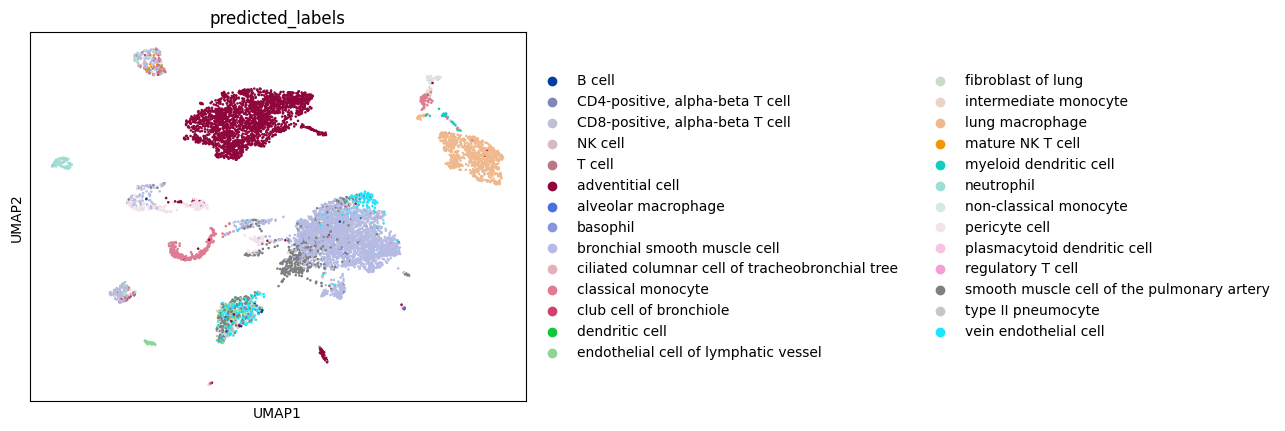

In [62]:
sc.pl.umap(query, color = 'predicted_labels') #transfered

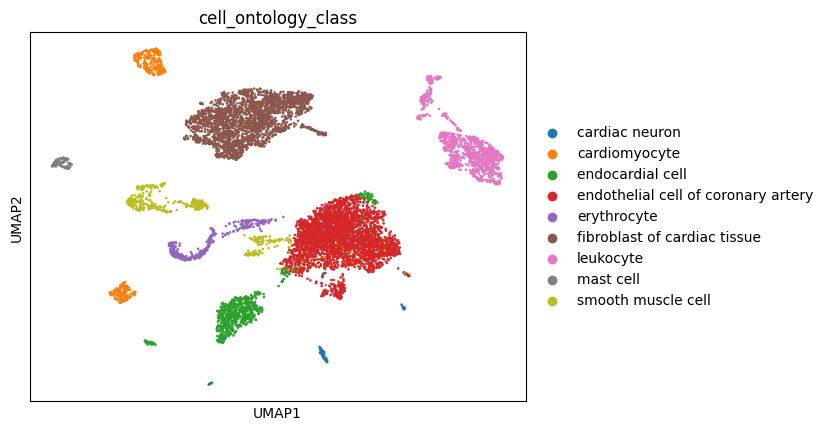

In [59]:
sc.pl.umap(query, color = 'cell_ontology_class') #actual

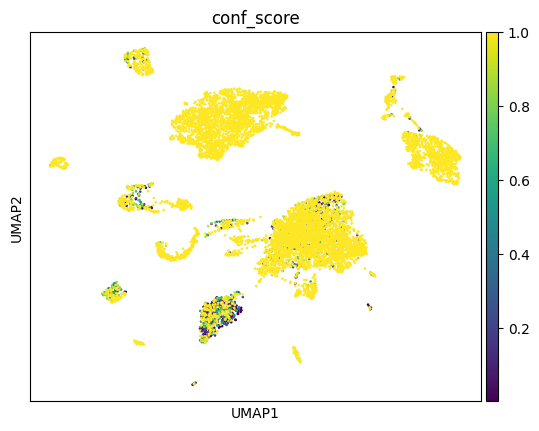

In [63]:
sc.pl.umap(query, color = 'conf_score')